In [1]:
import time, os
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from get_dataset import load_dataset
from get_dataset import get_trainset
from get_dataset import scaler_user
from embedding import embedding_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
created_time = int(time.time()) 
user, item, label = load_dataset()

rent = user[:,5].astype(np.float32)
body = user[:,6].astype(np.float32)
user = user[:,0:5].astype(np.float32)
label = to_categorical(label[:,1], 3)

id = item[:,0].astype(np.float32)
cat = item[:,1].astype(np.float32)
item = item[:,2].astype(np.float32)

In [3]:
user[:,0] = (user[:,0]-34)/117
user[:,1] = (user[:,1]-137.3)/163
user[:,2] = (user[:,2]-165.8)/29
user[:,3] = (user[:,3]-35)/14
user[:,4] = (user[:,4]-3.2)/9

item = (item-12)/60

In [4]:
print(item)

[ 0.03333334  0.         -0.13333334 ... -0.06666667  0.06666667
  0.06666667]


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rent_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 body_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 cat_input (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 id_input (InputLayer)          [(None, 1)]          0           []                               
                                                                                              

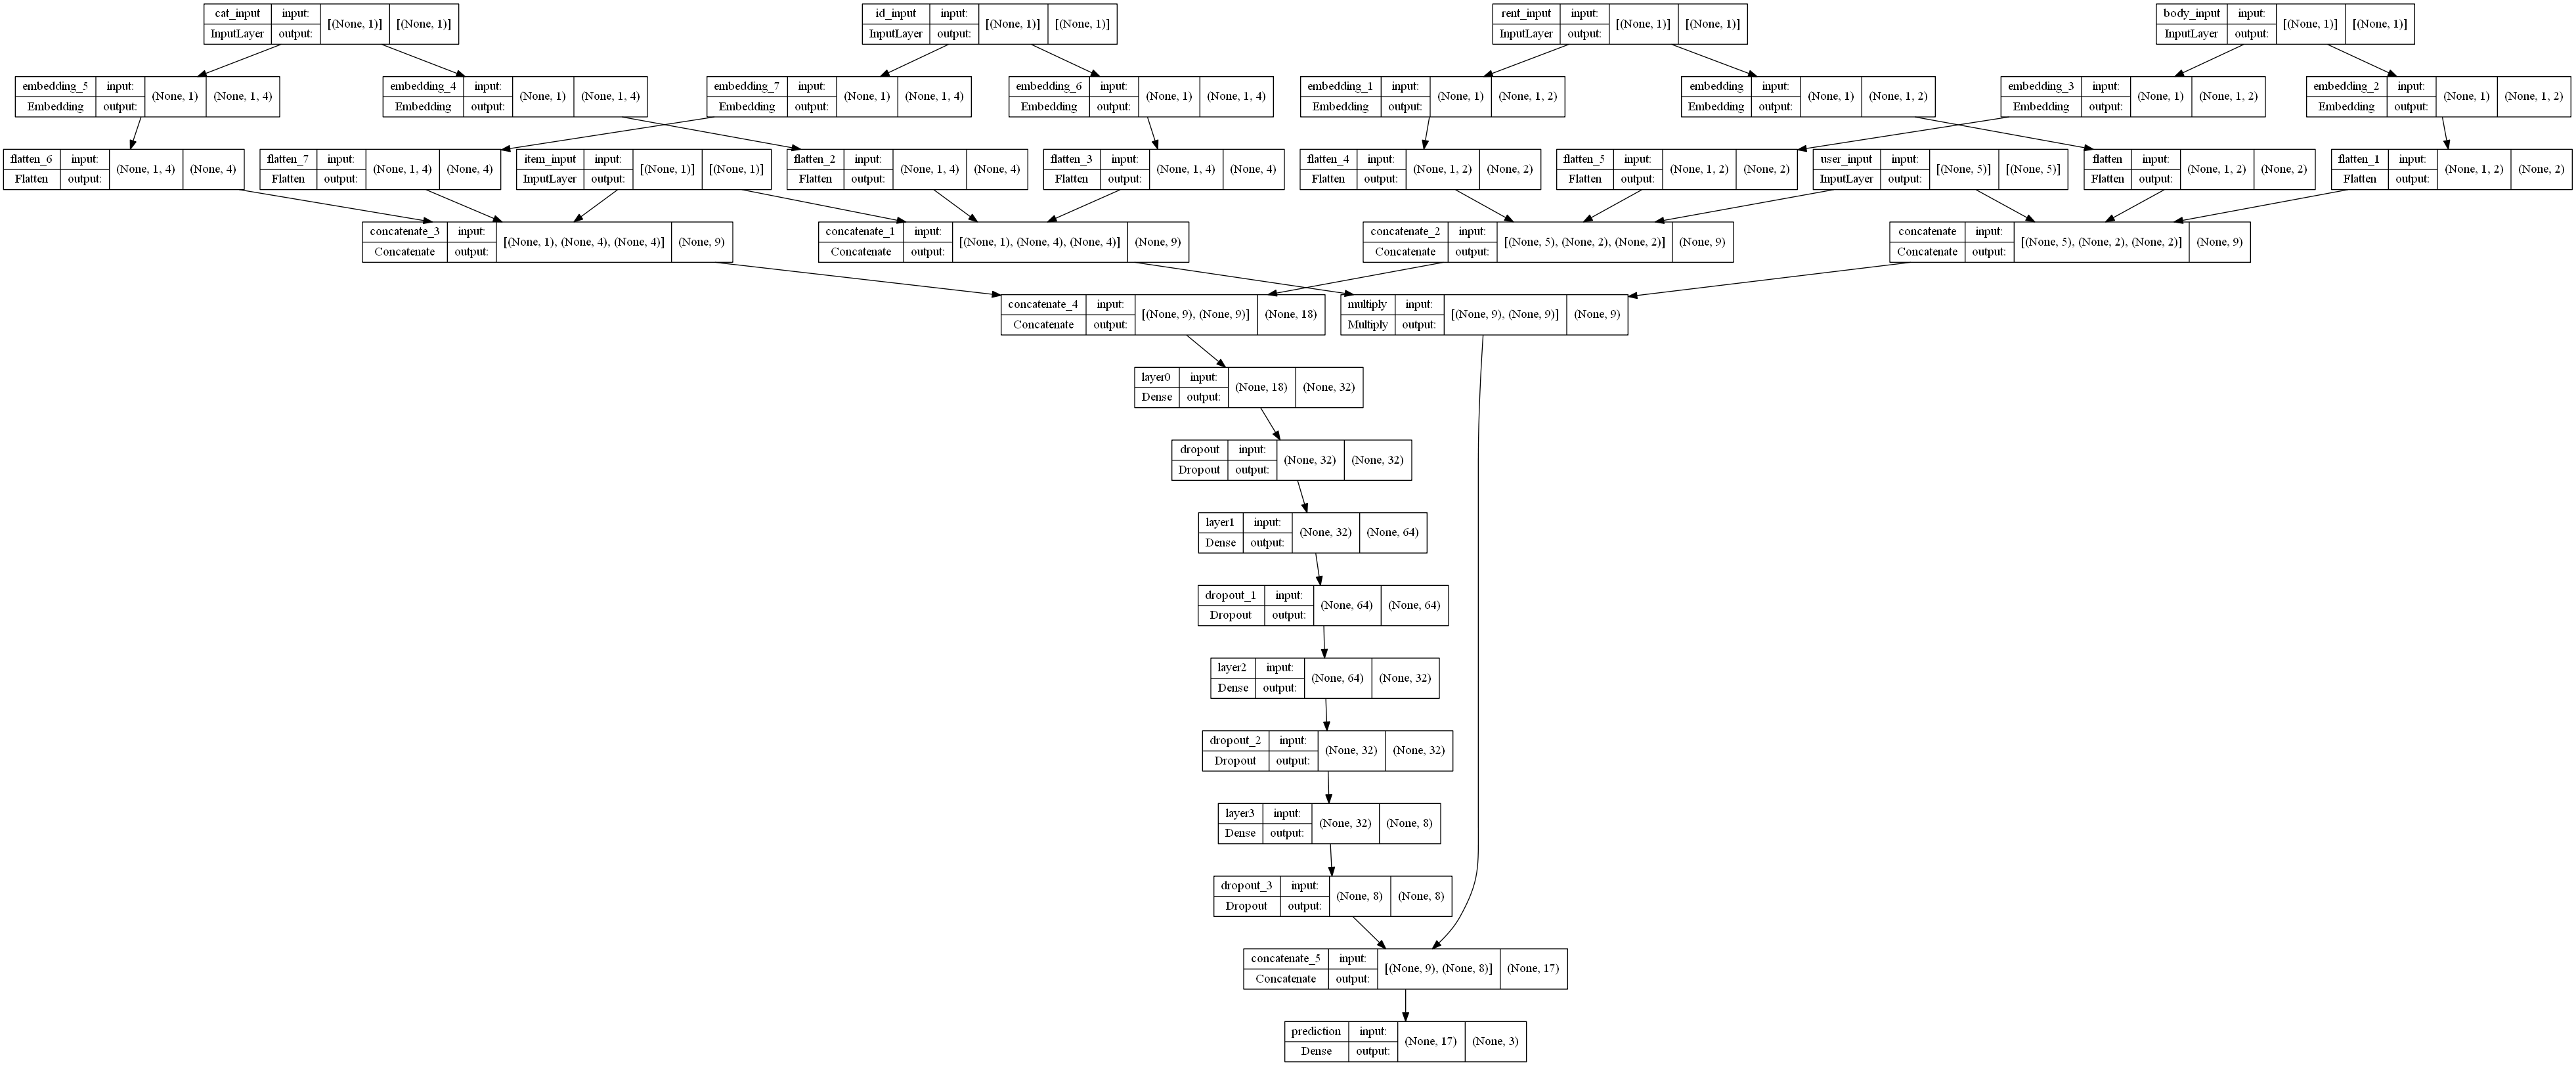

In [5]:
model = embedding_model()
model.summary()
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [6]:
user_train, user_val, rent_train, rent_val, body_train, body_val, item_train, item_val, cat_train, cat_val, id_train, id_val, label_train, label_val = train_test_split(user, rent, body, item, cat, id, label, test_size=0.1, random_state=2022)

print(np.shape(user_train))
print(np.shape(rent_train))
print(np.shape(body_train))
print(np.shape(item_train))
print(np.shape(cat_train))
print(np.shape(id_train))
print(np.shape(label_train))

(173268, 5)
(173268,)
(173268,)
(173268,)
(173268,)
(173268,)
(173268, 3)


In [7]:
print(label_train)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [8]:
cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0.0001, patience=5, verbose=1, mode='min',
    baseline=None, restore_best_weights=True
)

Epoch 1/50
5415/5415 [==============================] - 16s 3ms/step - loss: 0.8131 - auc: 0.8057 - accuracy: 0.7303 - val_loss: 0.7465 - val_auc: 0.8379 - val_accuracy: 0.7399
Epoch 2/50
5415/5415 [==============================] - 14s 3ms/step - loss: 0.7529 - auc: 0.8280 - accuracy: 0.7376 - val_loss: 0.7165 - val_auc: 0.8643 - val_accuracy: 0.7399
Epoch 3/50
5415/5415 [==============================] - 14s 3ms/step - loss: 0.7065 - auc: 0.8615 - accuracy: 0.7386 - val_loss: 0.6804 - val_auc: 0.8742 - val_accuracy: 0.7420
Epoch 4/50
5415/5415 [==============================] - 15s 3ms/step - loss: 0.6691 - auc: 0.8777 - accuracy: 0.7431 - val_loss: 0.6577 - val_auc: 0.8810 - val_accuracy: 0.7478
Epoch 5/50
5415/5415 [==============================] - 15s 3ms/step - loss: 0.6451 - auc: 0.8859 - accuracy: 0.7486 - val_loss: 0.6445 - val_auc: 0.8846 - val_accuracy: 0.7529
Epoch 6/50
5415/5415 [==============================] - 15s 3ms/step - loss: 0.6292 - auc: 0.8908 - accuracy: 0.751

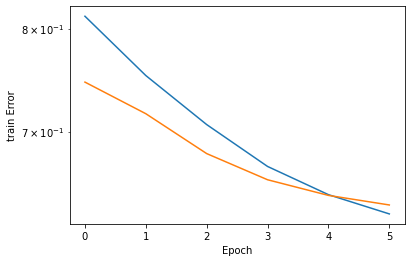

In [9]:
loss = 'categorical_crossentropy'
model.compile(optimizer=Adam(learning_rate = 0.0001), loss=loss, metrics=[tf.keras.metrics.AUC(),'accuracy'])
history = model.fit([user_train, rent_train, body_train, id_train, cat_train, item_train], label_train, epochs=50, batch_size=32, validation_data=([user_val, rent_val, body_val, id_val, cat_val, item_val], label_val),callbacks=[cb])

# os.mkdir(f"model/{loss}_{created_time}")
# model.save(f'model/{loss}_{created_time}/model.h5')

pd.Series(history.history['loss']).plot(logy=True)
pd.Series(history.history['val_loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("train Error")
# plt.savefig(f"model/{loss}_{created_time}/train_error.png")
plt.show()


In [13]:
print(label_val)

[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


#Predict
y_prediction = model.predict([user_val, rent_val, body_val, id_val, cat_val, item_val])


# #Create confusion matrix and normalizes it over predicted (columns)
label = np.argmax(label_val, axis = 1)

y= np.argmax(y_prediction, axis = 1)

result = confusion_matrix(label, y)


print(y_prediction)
# plt.tight_layout()
# plt.ylabel('True label')
# plt.xlabel('Predicted label')

[[0.16227122 0.68714166 0.15058716]
 [0.13664581 0.72177565 0.14157854]
 [0.14691393 0.7046279  0.14845826]
 ...
 [0.12968378 0.7394899  0.13082632]
 [0.13391124 0.7266837  0.13940512]
 [0.14314571 0.6961862  0.16066808]]


ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (2).

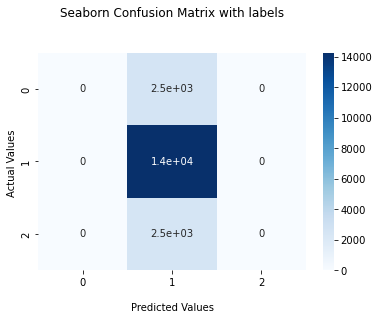